<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_6_residual_networks_res_net_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

In [30]:
class Residual(nn.Module):

  def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
  
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

In [31]:
blk = Residual(3,3, strides=1)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [32]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [33]:
b1 = nn.Sequential(
  nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
  nn.BatchNorm2d(64), nn.ReLU(),
  nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [34]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):

  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

In [35]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))

In [36]:
b3 = nn.Sequential(*resnet_block(64, 128, 2))

In [37]:
b4 = nn.Sequential(*resnet_block(128, 256, 2))

In [38]:
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [39]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [40]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [41]:
def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 2

In [42]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [43]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [44]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      if isinstance(X, list):
        X = [x.to(device) for x in X]
      else:
        X = X.to(device)
      y = y.to(device)
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [45]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):

  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  print('training on', device)
  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  num_batches = len(train_iter)

  train_x = []
  test_x = []
  train_loss = []
  train_acc = []
  test_acc = []
  for epoch in range(num_epochs):
    metric = Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      y_hat = net(X)
      l = loss(y_hat, y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
      train_l = metric[0] / metric[2]
      train_a = metric[1] / metric[2]
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        train_loss.append(train_l)
        train_acc.append(train_a)
        train_x.append(epoch + (i + 1) / num_batches)
    test_acc.append(evaluate_accuracy_gpu(net, test_iter))
    test_x.append(epoch + 1)
    print(f'epoch: {(epoch + 1):f}, train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
          f'test acc {test_acc[-1]:.3f}')

  print(f'train loss {train_loss[-1]:.3f}, train acc {train_acc[-1]:.3f}, '
          f'test acc {test_acc[-1]:.3f}')
  plt.plot(train_x, train_loss, 'r')
  plt.plot(train_x, train_acc, 'b')
  plt.plot(test_x, test_acc, 'g')
  plt.show()

In [46]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [47]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  
  def add(self, *args):
    self.data = [a + float(b) for a,b in zip(self.data, args)]

  def reset(self):
    self.data = [0.0] * len(self.data)
    
  def __getitem__(self, idx):
    return self.data[idx]

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

training on cuda:0
epoch: 1.000000, train loss 0.495, train acc 0.826, test acc 0.822
epoch: 2.000000, train loss 0.260, train acc 0.904, test acc 0.890
epoch: 3.000000, train loss 0.195, train acc 0.928, test acc 0.899
epoch: 4.000000, train loss 0.151, train acc 0.945, test acc 0.875
epoch: 5.000000, train loss 0.114, train acc 0.959, test acc 0.866
epoch: 6.000000, train loss 0.085, train acc 0.971, test acc 0.909
epoch: 7.000000, train loss 0.057, train acc 0.980, test acc 0.901
epoch: 8.000000, train loss 0.043, train acc 0.986, test acc 0.809
epoch: 9.000000, train loss 0.031, train acc 0.990, test acc 0.907
epoch: 10.000000, train loss 0.018, train acc 0.995, test acc 0.909
train loss 0.018, train acc 0.995, test acc 0.909


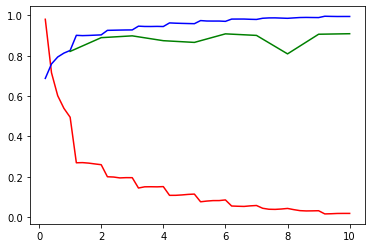

In [48]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())